In [1]:
import numpy as np
import matplotlib.pyplot as plt

Synchronization = 100%   /  Updates = 528 / Eve's updates = 85
Machines have been synchronized.
Time taken = 4.905343770980835 seconds.
Updates = 528.
Eve's machine is only 0 % synced with Alice's and Bob's and she did 85 updates.


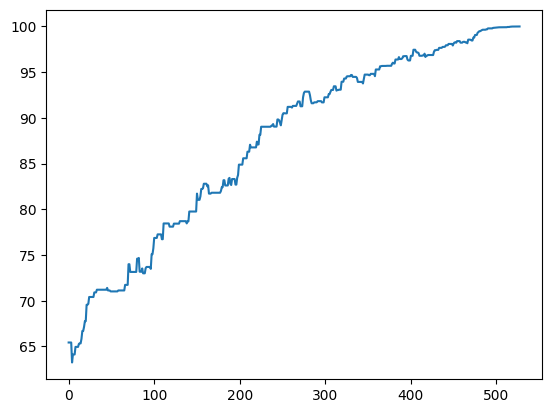

In [2]:
def theta(t1, t2):
	return 1 if t1 == t2 else 0

def hebbian(W, X, sigma, tau1, tau2, l):
	for (i, j), _ in np.ndenumerate(W):
		W[i, j] += X[i, j] * tau1 * theta(sigma[i], tau1) * theta(tau1, tau2)
		W[i, j] = np.clip(W[i, j] , -l, l)

def anti_hebbian(W, X, sigma, tau1, tau2, l):
	for (i, j), _ in np.ndenumerate(W):
		W[i, j] -= X[i, j] * tau1 * theta(sigma[i], tau1) * theta(tau1, tau2)
		W[i, j] = np.clip(W[i, j], -l, l)

def random_walk(W, X, sigma, tau1, tau2, l):
	for (i, j), _ in np.ndenumerate(W):
		W[i, j] += X[i, j] * theta(sigma[i], tau1) * theta(tau1, tau2)
		W[i, j] = np.clip(W[i, j] , -l, l)



class TreeParityMachine:
    def __init__(self, N, K, L):
        self.N = N
        self.K = K
        self.L = L
        self._r()

    def _r(self):
        self.W = np.random.randint(-self.L, self.L + 1, size=(self.K, self.N))
    
    def sample_X(self):
        return np.random.randint(-self.L, self.L + 1, size=(self.K,  self.N))
    
    def forward(self, X):
        self.X = X#.reshape((self.K, self.N))
        self.sgn = np.sign((self.W * self.X).sum(axis=1))
        self.y = self.sgn.prod()
        return self.y

    def update(self, y_other, update_rule='hebian'):
        sigma = self.sgn
        W = self.W
        tau1 = self.y
        tau2 = y_other
        X = self.X

        l = self.L

        if (self.y == y_other):
            if update_rule == 'hebbian':
                hebbian(W, X, sigma, tau1, tau2, l)
            elif update_rule == 'anti_hebbian':
                anti_hebbian(W, X, sigma, tau1, tau2, l)
            elif update_rule == 'random_walk':
                random_walk(W, X, sigma, tau1, tau2, l)
            else:
                raise Exception("Invalid update rule. Valid update rules are: " + 
                "\'hebbian\', \'anti_hebbian\' and \'random_walk\'.")
    
import time
import sys
k = 100
n = 10
l = 10
update_rules = ['hebbian', 'anti_hebbian', 'random_walk']
update_rule = update_rules[0]

Alice = TreeParityMachine(n, k, l)
Bob = TreeParityMachine(n, k, l)
Eve = TreeParityMachine(n, k, l)

def sync_score(m1, m2):
	return 1.0 - np.average(1.0 * np.abs(m1.W - m2.W)/(2 * l))

sync = False 
nb_updates = 0
nb_eve_updates = 0 
start_time = time.time()
sync_history = [] 

while(not sync):

	X = Alice.sample_X()

	tauA = Alice.forward(X) 
	tauB = Bob.forward(X) 
	tauE = Eve.forward(X) 
	Alice.update(tauB, update_rule)
	Bob.update(tauA, update_rule)

	if tauA == tauB == tauE:
		Eve.update(tauA, update_rule)
		nb_eve_updates += 1

	nb_updates += 1

	score = 100 * sync_score(Alice, Bob) 

	sync_history.append(score)

	sys.stdout.write('\r' + "Synchronization = " + str(int(score)) + "%   /  Updates = " + str(nb_updates) + " / Eve's updates = " + str(nb_eve_updates)) 
	if score == 100:
		sync = True

end_time = time.time()
time_taken = end_time - start_time

#Print results
print ('\nMachines have been synchronized.')
print ('Time taken = ' + str(time_taken)+ " seconds.")
print ('Updates = ' + str(nb_updates) + ".")

#See if Eve got what she wanted:
eve_score = 100 * int(sync_score(Alice, Eve))
if eve_score > 100:
	print("Oops! Nosy Eve synced her machine with Alice's and Bob's !")
else:
	print("Eve's machine is only " + str(eve_score) + " % " + "synced with Alice's and Bob's and she did " + str(nb_eve_updates) + " updates.") 

import matplotlib.pyplot as mpl
mpl.plot(sync_history)
mpl.show()


In [3]:
Bob.sample_X().shape

(100, 10)